In [ ]:
from collections import Counter
from sklearn import model_selection
from pysurvival.utils.display import correlation_matrix
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
def load_data(fp='.'):

    # Sensor data
    data = pd.read_csv(fp + '/PdM_telemetry.csv.gz')

    # Error alarm logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_errors.csv.gz'),
        how='left', on=['datetime', 'machineID'])

    # Failure logs
    data = data.merge(
        pd.read_csv(fp + '/PdM_failures.csv.gz'),
        how='left', on=['datetime', 'machineID'])

    # Formatting
    data.datetime = pd.to_datetime(data.datetime)

    return data

In [ ]:
raw_data = load_data()
raw_data.head(10)

In [ ]:
raw_data.nunique()

In [70]:
def censoring_augmentation(raw_data, n_samples=10, max_lifetime=150, min_lifetime=10, seed=123):

    error_ids = raw_data.errorID.dropna().sort_values().unique().tolist()
    np.random.seed(seed)
    pbar = tqdm.tqdm(total=n_samples, desc='augmentation')

    samples = []  # output

    while len(samples) < n_samples:
        
        censor_timing = np.random.randint(min_lifetime, max_lifetime)
        machine_id = np.random.randint(100) + 1
        tmp = raw_data[raw_data.machineID == machine_id]
        tmp = tmp.drop('machineID', axis=1).set_index('datetime').sort_index()

        failures = tmp[~tmp.failure.isnull()]
        if failures.shape[0] < 2:
            continue

        failure_id = np.random.randint(failures.shape[0])
        failure = failures.iloc[failure_id]
        event_time = failure.name
        start_date = tmp.index.values[0] if failure_id == 0 else failures.iloc[failure_id - 1].name

        # censoring
        cycle = tmp[start_date:event_time]
        cycle = cycle.iloc[:censor_timing]

        if not cycle.shape[0] == censor_timing:
            continue

        numerical_features = cycle.agg(['min', 'max', 'mean']).unstack().reset_index()
        numerical_features['feature'] = numerical_features.level_0.str.cat(numerical_features.level_1, sep='_')
        numerical_features = numerical_features.pivot_table(columns='feature', values=0)

        categorical_features = pd.DataFrame(Counter(cycle.errorID), columns=error_ids, index=[0])

        sample = pd.concat([numerical_features, categorical_features], axis=1)
        sample[['machine_id', 'lifetime', 'broken']] = machine_id, censor_timing, 0
        samples.append(sample)
        pbar.update(1)

    pbar.close()
    return pd.concat(samples).reset_index(drop=True).fillna(0)

In [71]:
health_censors = censoring_augmentation(raw_data, n_samples=1000, max_lifetime=200, min_lifetime=3)
health_censors

augmentation: 100%|██████████| 1000/1000 [00:14<00:00, 69.19it/s]


,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,machine_id,lifetime,broken
0,130.706018,100.236134,72.092543,586.941563,448.942591,338.891195,51.424300,39.794041,28.741474,212.028491,170.740329,136.291010,0,0,0,0,0,67,112,0
1,114.678705,101.231155,76.547574,522.074447,431.497500,307.778433,50.792066,40.492661,31.052696,195.527742,166.275130,135.888408,0,0,0,0,0,84,20,0
2,135.959689,100.077178,73.309133,581.808774,448.433424,345.686347,53.095653,40.262504,29.773657,211.858373,173.794237,134.905936,0,0,1,0,0,58,126,0
3,116.473551,98.781988,79.125328,531.943470,453.146862,300.562373,54.155983,39.554378,21.629032,208.756064,168.011703,132.177014,0,0,0,0,0,48,99,0
4,116.927449,97.906122,80.970162,553.496437,443.786734,306.918582,50.899053,39.540444,27.994116,210.998009,174.987418,133.822276,0,0,0,0,0,47,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,129.326828,100.226996,72.139048,563.773486,457.574190,304.169569,52.120127,39.739339,27.957389,209.944130,171.202096,136.707254,0,0,0,0,0,16,173,0
996,127.329025,100.172188,75.271758,565.169030,448.548975,338.088286,52.203383,39.610840,26.958497,207.817766,168.050700,130.010419,0,0,0,0,1,92,106,0
997,129.873496,100.316682,69.633305,591.043686,445.510045,314.715558,53.317967,39.476418,21.664048,219.621927,170.899436,134.810529,0,0,0,0,0,73,194,0
998,130.022835,99.306881,72.192132,561.416440,455.304072,325.983463,53.435171,39.743497,28.283177,212.944271,170.582113,130.316605,0,0,0,0,0,28,159,0


In [72]:
def generate_run_to_failure(raw_data, health_censor_aug=1000,
                            min_lifetime=2, max_lifetime=300,
                            seed=123, outfn=None):

    run_to_failure = []
    error_ids = raw_data.errorID.dropna().sort_values().unique().tolist()

    for machine_id, g in tqdm.tqdm(raw_data.groupby('machineID'), desc='run-to-failure'):
        g = g.set_index('datetime').sort_index()

        start_date = g.index.values[0]
        failures = g.loc[~g.failure.isnull()]

        for event_time, event in failures.iterrows():
            # Extracting a single cycle/process
            cycle = g[start_date:event_time].drop('machineID', axis=1)

            lifetime = (event_time - start_date).days
            if lifetime < 1:
                start_date = event_time
                continue

            numerical_features = cycle.agg(['min', 'max', 'mean']).unstack().reset_index()
            numerical_features['feature'] = numerical_features.level_0.str.cat(numerical_features.level_1, sep='_')
            numerical_features = numerical_features.pivot_table(columns='feature', values=0)

            categorical_features = pd.DataFrame(Counter(cycle.errorID), columns=error_ids, index=[0])

            sample = pd.concat([numerical_features, categorical_features], axis=1)
            sample[['machine_id', 'lifetime', 'broken']] = machine_id, lifetime, 1

            run_to_failure.append(sample)
            start_date = event_time

    run_to_failure = pd.concat(run_to_failure, axis=0).fillna(0).reset_index(drop=True)

    health_censors = censoring_augmentation(raw_data,
        n_samples=health_censor_aug,
        min_lifetime=min_lifetime,
        max_lifetime=max_lifetime,
        seed=seed)

    run_to_failure = pd.concat([run_to_failure, health_censors])

    # Shuffle
    run_to_failure = run_to_failure.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    if outfn is not None:
        run_to_failure.to_csv(outfn, index=False)

    return run_to_failure

In [73]:
data = generate_run_to_failure(raw_data, health_censor_aug=1000)

augmentation: 100%|██████████| 1000/1000 [00:14<00:00, 67.83it/s]


In [74]:
data.head(10)

,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,machine_id,lifetime,broken
0,123.101245,101.258694,75.266485,601.753059,446.724056,293.178188,53.923271,40.110240,22.122225,216.791144,172.707812,134.138392,0,0,0,0,0,13,270,0
1,151.158156,100.279878,75.287658,562.356301,442.775023,313.077652,56.043723,39.906598,26.192913,205.589004,170.291238,124.865350,0,1,0,0,0,23,117,0
2,140.178959,100.470325,72.547204,571.708154,444.770170,311.030149,57.883382,39.766870,29.445443,206.168051,169.932849,131.142585,2,0,0,0,0,29,209,0
3,108.988777,97.411021,84.321113,543.790394,447.322058,331.946939,43.713515,40.157029,31.471522,206.350580,190.583388,161.787364,0,0,0,0,0,85,7,0
4,142.062387,99.990618,66.886090,641.846493,443.941369,229.993390,61.159769,40.305105,23.807919,228.104567,171.942603,118.777311,1,2,3,1,0,48,60,1
5,147.659745,101.456228,63.741739,614.836130,450.062520,297.112946,62.624092,40.709559,22.605286,255.124717,175.285365,124.272505,2,0,0,2,0,31,30,1
6,128.736186,99.876388,72.941666,555.512712,440.797874,333.452041,55.469367,40.155879,27.388594,210.322553,168.414936,127.405893,1,0,1,0,0,24,89,0
7,131.484940,99.705013,58.485426,617.486427,451.288860,284.698822,63.470831,40.442942,24.656732,232.350007,170.781877,116.601124,5,1,1,3,3,63,90,1
8,142.877908,100.740110,68.525972,594.248005,444.154104,268.624898,61.809072,40.291335,24.255324,226.326728,170.249024,111.241221,2,0,1,1,1,93,75,1
9,150.089034,105.936976,78.371289,608.292545,449.354745,302.572590,56.464328,39.857245,26.375925,221.395828,172.992493,131.455384,0,0,0,0,0,71,245,0


Text(0.5, 1.0, 'Histogram - survival time')

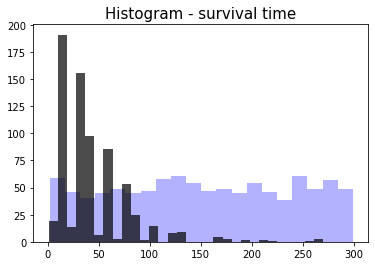

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))

# Showing the histogram of the survival times for the censoring
time_0 = data.loc[ data['broken'] == 0, 'lifetime']
ax.hist(time_0, bins=20, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = data.loc[ data['broken'] == 1, 'lifetime']
ax.hist(time_1, bins=30, alpha=0.7, color='black', label = 'broken')
ax.set_title( 'Histogram - survival time', fontsize=15)


In [89]:
def generate_validation_sets(method='kfold', n_splits=5, seed=123, outdir=None):

    validation_sets = []

    if method == 'kfold':
        # K-fold cross validation
        assert type(n_splits) == int
        assert n_splits > 2

        raw_data = load_data()

        kfold = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        for i, (train_index, test_index) in enumerate(kfold.split(np.arange(100))):
            
            print('K-fold {}/{}'.format(i+1, n_splits))
            # train/test split by machine ID
            train_machines = raw_data[raw_data.machineID.isin(train_index)]
            test_machines = raw_data[raw_data.machineID.isin(test_index)]
            # print('train:', train_machines.shape)
            # print('test:', test_machines.shape)

            # convert the two sets into run-to-failure data
            train_censored_data = generate_run_to_failure(
                train_machines, health_censor_aug=len(train_index)*10, seed=seed)
            test_consored_data = generate_run_to_failure(
                test_machines, health_censor_aug=len(test_index)*10, seed=seed)

            # print('train:', train_censored_data.shape)
            # print('test:', test_consored_data.shape)

            validation_sets.append((train_censored_data, test_consored_data))

            if outdir is not None:
                train_censored_data.to_csv(outdir + f'/train_{i}.csv.gz', index=False)
                test_consored_data.to_csv(outdir + f'/test_{i}.csv.gz', index=False)

    elif method == 'leave-one-out':
        raise NotImplementedError

    return validation_sets


In [95]:
def load_validation_sets(filepath, n_splits=5):
    return [(pd.read_csv(filepath + f'/train_{i}.csv.gz'),
             pd.read_csv(filepath + f'/test_{i}.csv.gz'))
             for i in range(n_splits)]

In [96]:
validation_sets = generate_validation_sets(n_splits=5, outdir='../../out/')

augmentation:  61%|██████    | 122/200 [00:02<00:01, 53.03it/s]/home/koki/miniconda3/envs/surv/lib/python3.7/site-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)
augmentation:  44%|████▎     | 349/800 [00:05<00:06, 68.09it/s]/home/koki/miniconda3/envs/surv/lib/python3.7/site-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)
augmentation: 100%|██████████| 200/200 [00:04<00:00, 48.67it/s]


In [101]:
validation_sets[0][0]  # Train
# validation_sets[0][1]  # Test

,pressure_max,pressure_mean,pressure_min,rotate_max,rotate_mean,rotate_min,vibration_max,vibration_mean,vibration_min,volt_max,volt_mean,volt_min,error1,error2,error3,error4,error5,machine_id,lifetime,broken
0,135.091764,100.304880,70.524988,601.140511,440.627272,282.231832,55.580450,40.587558,26.297965,222.297706,171.146973,128.243147,0,1,1,0,0,14,15,1
1,139.237385,103.729121,66.835760,604.295929,448.912120,285.929409,52.793300,39.675883,25.057332,223.062537,173.431858,124.680721,1,0,0,0,0,62,12,1
2,125.020323,99.257257,71.620122,586.370411,455.393358,295.786840,53.324125,39.683161,23.530023,204.709289,171.675424,135.778322,0,0,0,0,0,54,138,0
3,122.863416,99.926035,73.834866,580.258794,443.996891,319.146860,65.747021,44.257223,30.306650,207.573207,171.700820,139.440925,0,0,0,0,1,64,85,0
4,124.589135,98.953123,73.580588,575.551538,455.386767,336.052027,59.060699,40.467475,24.440361,208.448131,168.683717,133.193037,0,0,0,0,0,49,152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,128.349483,99.184051,65.013499,563.042332,452.722299,317.950706,53.700317,40.445770,26.494234,215.711368,169.439485,129.238251,0,0,0,0,0,98,279,0
1370,145.165165,103.495870,72.237497,588.131667,452.826803,314.644841,59.657057,41.638999,26.163300,222.075900,171.638725,134.470095,1,1,0,1,0,20,15,1
1371,131.215568,99.605590,76.080822,573.681069,450.459882,309.684655,49.896562,40.211328,28.643591,207.143334,171.980556,132.001571,0,0,0,0,0,95,101,0
1372,124.589135,98.935652,73.580588,575.551538,454.409033,336.052027,53.131856,40.276966,24.440361,208.448131,168.561168,133.193037,0,0,0,0,0,49,141,0


<AxesSubplot:>

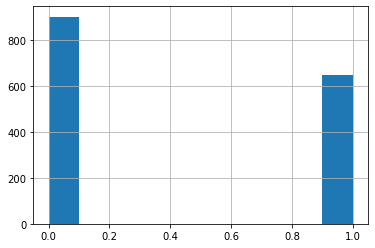

In [66]:
validation_sets[0][0].broken.hist()  # Train


<AxesSubplot:>

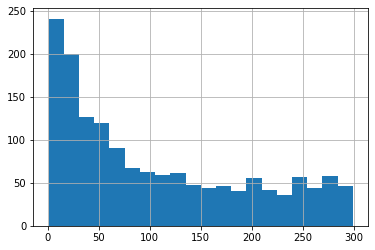

In [67]:
validation_sets[0][0].lifetime.hist(bins=20)

In [105]:
def plot_event_histograms(sample_data):

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(12, 4))

    # Counting the number of occurrences for each category 
    data = Counter(sample_data['broken'].replace({0:'not broken yet', 1:'broken'}))
    category = list(data.keys())
    counts = list(data.values())
    idx = range(len(counts))

    # Displaying the occurrences of the event/censoring
    ax1.bar(idx, counts)
    ax1.set_xticks(idx)
    ax1.set_xticklabels(category)
    ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

    # Showing the histogram of the survival times for the censoring
    time_0 = sample_data.loc[ sample_data['broken'] == 0, 'lifetime']
    ax2.hist(time_0, bins=20, alpha=0.3, color='blue', label = 'not broken yet')

    # Showing the histogram of the survival times for the events
    time_1 = sample_data.loc[ sample_data['broken'] == 1, 'lifetime']
    ax2.hist(time_1, bins=30, alpha=0.7, color='black', label = 'broken')
    ax2.set_title( 'Histogram - survival time', fontsize=15)

    # Displaying everything side-by-side
    plt.legend(fontsize=15)
    plt.show()

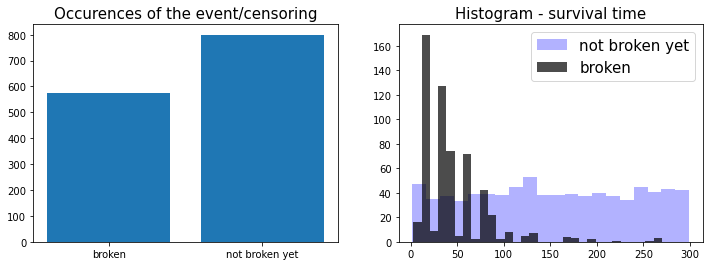

In [106]:
plot_event_histograms(sample_data=validation_sets[0][0])

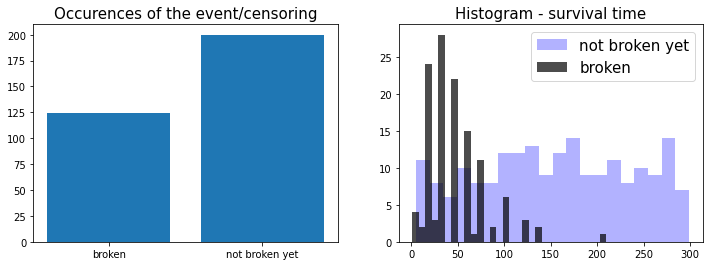

In [107]:
plot_event_histograms(sample_data=validation_sets[0][1])